#Playing with Caffe to extract features from pretrained models

* Based on http://nbviewer.ipython.org/github/BVLC/caffe/blob/dev/examples/filter_visualization.ipynb
* A bit messy :(

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '/home/ubuntu/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

In [9]:
caffe.set_mode_cpu()
net = caffe.Classifier(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                       caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
# ImageNet mean
net.transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
# the reference model operates on images in [0,255] range instead of [0,1]
net.transformer.set_raw_scale('data', 255)
# the reference model has channels in BGR order instead of RGB
net.transformer.set_channel_swap('data', (2, 1, 0))

In [21]:
img = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
print img.shape

(360, 480, 3)


In [30]:
scores = net.predict([img])

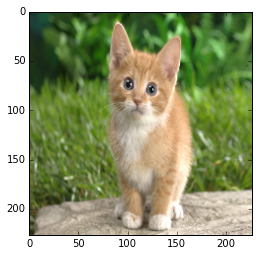

In [23]:
# data[4] is the centred crop
plt.imshow(net.transformer.deprocess('data', net.blobs['data'].data[4]))

In [13]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [235]:
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[4].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n06596364 comic book'
 'n07248320 book jacket, dust cover, dust jacket, dust wrapper'
 'n02895154 breastplate, aegis, egis' 'n04584207 wig'
 'n04367480 swab, swob, mop']


Scores are averaged across 5 crops x 2 reflections

In [42]:
print labels[scores.flatten().argsort()[-1:-6:-1]]

['n02123045 tabby, tabby cat' 'n02123159 tiger cat'
 'n02124075 Egyptian cat' 'n02119022 red fox, Vulpes vulpes'
 'n02127052 lynx, catamount']


###Activations for the last fully-connected layer

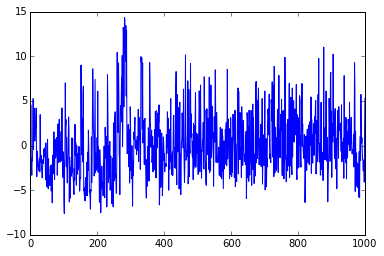

In [16]:
feat = net.blobs['fc8'].data[4]
plt.plot(feat.flat)

###Get activations for my dataset

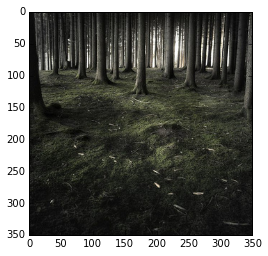

In [50]:
img = caffe.io.load_image('/home/ubuntu/data/images/ambient/a1003262118.jpg')
plt.imshow(img)

In [51]:
print labels[net.predict([img]).flatten().argsort()[-1:-6:-1]]

['n03930313 picket fence, paling' 'n03733281 maze, labyrinth'
 'n04005630 prison, prison house' 'n04040759 radiator'
 'n04239074 sliding door']


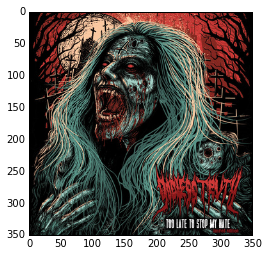

In [173]:
img = caffe.io.load_image('/home/ubuntu/data/images/metal/a2000823317.jpg')
plt.imshow(img)

In [66]:
print labels[net.predict([img]).flatten().argsort()[-1:-6:-1]]

['n03724870 mask' 'n02088094 Afghan hound, Afghan'
 'n02097474 Tibetan terrier, chrysanthemum dog' 'n02105251 briard'
 'n04599235 wool, woolen, woollen']


In [198]:
def get_img_features(img):
    net.predict([img])
    return net.blobs['fc7'].data.mean(axis=0)

In [200]:
caffe.set_mode_cpu()
%timeit -n3 -r3 get_img_features(img)

3 loops, best of 3: 1.31 s per loop


In [201]:
caffe.set_mode_gpu()
%timeit -n3 -r3 get_img_features(img)

3 loops, best of 3: 62.7 ms per loop


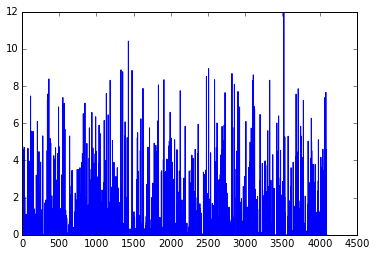

In [199]:
plt.plot(get_img_features(img))

###Extract features for all the images in the dataset

There are definitely more efficient ways, but quick and dirty is good enough for now

In [143]:
sys.path.append('/home/ubuntu/bandcamp-deep-learning/')
from theano_latest.misc import pkl_utils

with open('/home/ubuntu/data/full.rgb.pkl.zip', 'rb') as dataset_file:
    dataset, label_to_index = pkl_utils.load(dataset_file)

In [203]:
caffe.set_mode_gpu()

from datetime import datetime
import numpy as np
import sys

dataset_features = {}
for subset, (data, labels) in dataset.iteritems():
    data_features = np.zeros(shape=(data.shape[0], 4096), dtype='float32')
    print(subset)
    for i, img in enumerate(data):
        assert img.shape == (3, 350, 350)
        data_features[i] = get_img_features(img.transpose(1, 2, 0))
        if i % 1000 == 0:
            print('%s: %d' % (datetime.now(), i))
            sys.stdout.flush()
    dataset_features[subset] = (data_features, labels)    

training
2015-06-16 05:38:42.188737: 0
2015-06-16 05:39:48.256427: 1000
2015-06-16 05:40:54.416751: 2000
2015-06-16 05:42:00.492283: 3000
2015-06-16 05:43:06.620126: 4000
2015-06-16 05:44:12.741538: 5000
2015-06-16 05:45:18.865741: 6000
2015-06-16 05:46:24.938489: 7000
validation
2015-06-16 05:47:31.185281: 0
testing
2015-06-16 05:48:37.124599: 0


In [204]:
with open('/home/ubuntu/data/full.caffenet-features.pkl.zip', 'wb') as out:
    pkl_utils.dump((dataset_features, label_to_index), out)

####Unimpressive results with RF and linear classification

In [222]:
!/home/ubuntu/.virtualenvs/bandcamp-deep-learning/bin/python /home/ubuntu/bandcamp-deep-learning/manage.py \
    run_random_forest_baseline --dataset-path ~/data/full.caffenet-features.pkl.zip --n-estimators 1000

Validation accuracy: 16.60%


In [216]:
from sklearn.linear_model import SGDClassifier
estimator = SGDClassifier(random_state=0, n_iter=1, warm_start=True)

In [218]:
try:
    for i in xrange(100):
        estimator.fit(*dataset_features['training'])
        if i % 5 == 0:
            print i, estimator.score(*dataset_features['validation'])
except KeyboardInterrupt:
    pass

0 0.124
5 0.123
10 0.117
15 0.13
20 0.128
25 0.115
30 0.125
35 0.103
40 0.108
45 0.123
50 0.115
55 0.13


###Would a better model yield better results?

Next step: repeat the above experiments with VGGNet

In [227]:
net = caffe.Classifier(caffe_root + 'models/VGG_ILSVRC_19_layers/VGG_ILSVRC_19_layers_deploy.prototxt',
                       caffe_root + 'models/VGG_ILSVRC_19_layers/VGG_ILSVRC_19_layers.caffemodel')
net.transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
net.transformer.set_raw_scale('data', 255)
net.transformer.set_channel_swap('data', (2, 1, 0))

In [228]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (10, 3, 224, 224)),
 ('conv1_1', (10, 64, 224, 224)),
 ('conv1_2', (10, 64, 224, 224)),
 ('pool1', (10, 64, 112, 112)),
 ('conv2_1', (10, 128, 112, 112)),
 ('conv2_2', (10, 128, 112, 112)),
 ('pool2', (10, 128, 56, 56)),
 ('conv3_1', (10, 256, 56, 56)),
 ('conv3_2', (10, 256, 56, 56)),
 ('conv3_3', (10, 256, 56, 56)),
 ('conv3_4', (10, 256, 56, 56)),
 ('pool3', (10, 256, 28, 28)),
 ('conv4_1', (10, 512, 28, 28)),
 ('conv4_2', (10, 512, 28, 28)),
 ('conv4_3', (10, 512, 28, 28)),
 ('conv4_4', (10, 512, 28, 28)),
 ('pool4', (10, 512, 14, 14)),
 ('conv5_1', (10, 512, 14, 14)),
 ('conv5_2', (10, 512, 14, 14)),
 ('conv5_3', (10, 512, 14, 14)),
 ('conv5_4', (10, 512, 14, 14)),
 ('pool5', (10, 512, 7, 7)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

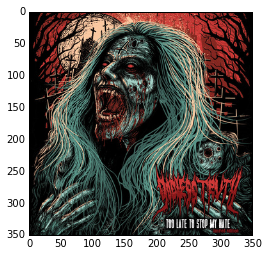

In [231]:
img = caffe.io.load_image('/home/ubuntu/data/images/metal/a2000823317.jpg')
plt.imshow(img)

In [236]:
print labels[net.predict([img]).flatten().argsort()[-1:-6:-1]]

['n06596364 comic book'
 'n07248320 book jacket, dust cover, dust jacket, dust wrapper'
 'n04584207 wig' 'n02895154 breastplate, aegis, egis'
 'n04367480 swab, swob, mop']


In [238]:
def get_img_features(img):
    net.predict([img])
    return net.blobs['fc7'].data.mean(axis=0)

In [242]:
caffe.set_mode_gpu()

from datetime import datetime
import numpy as np
import sys

dataset_features = {}
for subset, (data, labels) in dataset.iteritems():
    data_features = np.zeros(shape=(data.shape[0], 4096), dtype='float32')
    print(subset)
    for i, img in enumerate(data):
        assert img.shape == (3, 350, 350)
        data_features[i] = get_img_features(img.transpose(1, 2, 0))
        if i % 500 == 0:
            print('%s: %d' % (datetime.now(), i))
            sys.stdout.flush()
    dataset_features[subset] = (data_features, labels)    

training
2015-06-16 06:36:02.936340: 0
2015-06-16 06:41:12.214104: 500
2015-06-16 06:46:21.475568: 1000
2015-06-16 06:51:30.779320: 1500
2015-06-16 06:56:40.044128: 2000
2015-06-16 07:01:49.373127: 2500
2015-06-16 07:06:58.626022: 3000
2015-06-16 07:12:07.887540: 3500
2015-06-16 07:17:17.140867: 4000
2015-06-16 07:22:26.382251: 4500
2015-06-16 07:27:35.609360: 5000
2015-06-16 07:32:44.890694: 5500
2015-06-16 07:37:54.128218: 6000
2015-06-16 07:43:03.431246: 6500
2015-06-16 07:48:12.826150: 7000
2015-06-16 07:53:22.113586: 7500
validation
2015-06-16 07:58:31.357590: 0
2015-06-16 08:03:40.496341: 500
testing
2015-06-16 08:08:49.633803: 0
2015-06-16 08:13:58.820823: 500


In [243]:
with open('/home/ubuntu/data/full.vggnet-features.pkl.zip', 'wb') as out:
    pkl_utils.dump((dataset_features, label_to_index), out)

In [244]:
!/home/ubuntu/.virtualenvs/bandcamp-deep-learning/bin/python /home/ubuntu/bandcamp-deep-learning/manage.py \
    run_random_forest_baseline --dataset-path ~/data/full.vggnet-features.pkl.zip --n-estimators 1000

Validation accuracy: 17.20%
